In [1]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import recall_score
from sklearn.metrics import auc as auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import json
import os
import glob
from natsort import natsorted
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
import PIL
from scipy import stats


In [2]:
def fold_roc_auc(folds, plotting=True, exclude_cells=None, method='median', fold_names=None):
    if exclude_cells is not None:
        folds = [filter_folder(fold, set(exclude_cells)) for fold in folds]
    if plotting:
        fig, ax = plt.subplots()
    for i, fold in enumerate(folds):
        (fpr, tpr, thresholds), auc = get_roc_auc(fold, method=method)
        if plotting and len(folds) > 1:
            if fold_names is not None:
                ax.plot(fpr, tpr, label=f'{fold_names[i]} - AUC: {auc:.3f}', alpha=0.75)
            else:
                ax.plot(fpr, tpr, label=f'ROC fold {i+1} - AUC: {auc:.3f}', alpha=0.5)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc_score(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    if plotting:

        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
        ax.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')
        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
               title=f"Receiver Operating Characteristic \nMedian Aggregration Cell Level Only\n AUC={mean_auc:.3f} $\pm${std_auc:.3f}")
        ax.legend(loc="lower right")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        plt.show()
    return mean_auc

In [3]:
def z_score_scipy(scores_np):
    #increases it by about 0.2%
    scores = stats.zscore(scores_np)
    #scores = ndarray
    delete = []
    for i in range(len(scores)):
        if (abs(scores[i]) > 3.3):
            delete.append(i)
    scores_np = np.delete(scores_np, delete)
    return np.mean(scores_np)



def dbscan(scores_np):
    X = []
    for score in scores_np:
        X.append(score)

    X = np.asarray(X)

    y = []
    for i in X:
        y.append(0)

    from sklearn.cluster import DBSCAN
    from sklearn.preprocessing import StandardScaler
    
    new_X = []
    for old_scores in X:
        new_X.append([old_scores, 1])
        
    new_X=np.asarray(new_X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(new_X)

    dbscan = DBSCAN(eps=0.01, min_samples = 5)
    clusters = dbscan.fit_predict(X_scaled)
    
    filtered_data = [] 
    for i in range(len(dbscan.labels_)):
        if(dbscan.labels_[i] != -1):
            filtered_data.append(new_X[i][0])
            
    if(len(filtered_data) > 0 ):
        return np.mean(np.float_(filtered_data))
    else:
        return -1


In [4]:
cell_types_li = ['basophil',
 'eosinophil',
 'erythroblast',
 'garbage',
 'ig',
 'lymphocyte',
 'monocyte',
 'neutrophil',
 'platelet']

In [5]:
def filter_folder(fold, exclusion):
    new_fold = {}
    for patient, data in fold.items():
        new_fold[patient] = {
            'label': data['label'],
            'predictions': []
        }        
        for pred, filename in zip(data['predictions'], data['files']):
            if os.path.basename(filename) not in exclusion:
                new_fold[patient]['predictions'].append(pred)
    return new_fold

In [6]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def get_roc_auc(fold_data, thresh=1, method='median'):
    labels = []
    confs  = []
    for patient, data in fold_data.items():
        if len(data['predictions'])  > thresh:
            labels.append(data['label'])
            confs.append(aggregate_scores(data['predictions'], method))
        else:
            print(f"Discluding patient {patient} for only have {len(data['predictions'])} cells")
    fpr, tpr, thresholds = roc_curve(labels, confs)
    auc = roc_auc_score(labels, confs)
    return (fpr, tpr, thresholds), auc
    

In [7]:
def aggregate_scores(score_list, method='median'):
    """
    :param score_list: confidence scores for a patient, in list or as a np array. Should be for a single patient
    :param method: aggregation method to use (recommend mean or median)
    :return: aggregated score (single float)
    """
    scores_np = np.float_(score_list)
    if method == 'median':
        return np.median(scores_np)
    elif method == 'mean':
        return np.mean(scores_np)
    elif method == 'max':
        return np.max(scores_np)
    elif method == 'min':
        return np.min(scores_np)
    elif method == 'range':
        return np.max(scores_np) - np.min(scores_np)
    elif method == 'chance':
        return 1
    elif method == 'std':
        return np.std(scores_np)
    elif method == 'split':
        s1 = scores_np[scores_np < np.median(scores_np)]
        s2 = scores_np[scores_np > np.median(scores_np)]
        return np.mean([np.mean(s1), np.mean(s2)])
    elif method == 'hist':
        bins = np.arange(0, 1.1, 0.1)
        return np.histogram(scores_np, bins=bins, density=True)[0]
    elif method == 'exclude':
        scores = scores_np[(np.abs(scores_np - 0.5)) < 0.4]
        if len(scores) < 1:
            return aggregate_scores(scores_np)
        else:
            return np.mean(scores)
    elif method == 'dbscan':
        return dbscan(scores_np)
    elif method == 'z-score':
        return z_score_scipy(scores_np)


In [8]:
method_perf = []
method_std = []
methods = ['mean', 'median', 'z-score']
amnts = np.arange(2, 11, 1)
good_patients = {p:v for p,v in all_patients.items() if len(v['predictions']) >= 100}
for method in methods:
    # sorting_folds
    auc_val_seeds = []
    seeds = np.arange(0, 10)
    for seed in seeds:
        cell_dist = []
        split_patients = [{} for  _ in range(len(amnts))]
        np.random.seed(seed)
        for patient, values in good_patients.items():
            for i, amnt in enumerate(amnts):
                split_patients[i][patient] = {
                    'predictions': np.random.choice(values['predictions'], replace=False, size=amnt),
                    'label': values['label']
                }
        auc_values = []
        for i, amnt in enumerate(amnts):
            auc_split = fold_roc_auc(split_patients[i:i+1], plotting=False)
            auc_values.append(auc_split)
        auc_val_seeds.append(auc_values)
    perf = np.mean(np.array(auc_val_seeds), axis=0)
    std = np.std(np.array(auc_val_seeds), axis=0)
    method_perf.append(perf)
    method_std.append(std)

NameError: name 'all_patients' is not defined

In [9]:
plt.figure()
for m, method in enumerate(methods):
    plt.plot(amnts, method_perf[m], marker='o', label=method)
    plt.fill_between(amnts, method_perf[m] - method_std[m]/2, method_perf[m] + method_std[m]/2, alpha=0.25)
plt.xlabel("Cell Amount")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC by Cell Count\n Averaged Across 10 seeds")
plt.legend()

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

NameError: name 'aucs_li' is not defined

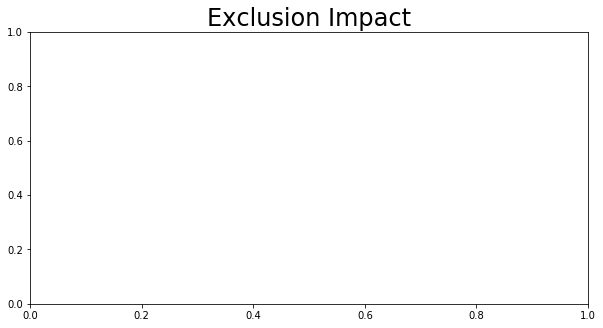

In [10]:
plt.figure(figsize=(10, 5))
plt.title("Exclusion Impact", fontsize=24)
width = 0.4
x_data_1 = np.arange(0, 9)
y_data_1 = np.array(aucs_li) - baseline
x_data_2 = np.arange(0, 9) + width
y_data_2 = np.array(aucs_li_man) - baseline
plt.bar(x_data_1, y_data_1, width=width, label="Automated")
plt.bar(x_data_2, y_data_2, width=width, label="Manually Verified")
plt.xticks(ticks=x_data + width/2, labels=cell_types_li, rotation=45,fontsize=20)
plt.ylabel("Impact on ROC", fontsize=20)
max_y = max(max(y_data_1), max(y_data_2))
# plt.ylim(min(y_data) - 0.0001, max_y)
plt.legend()
plt.show()

In [11]:
baseline

NameError: name 'baseline' is not defined

In [12]:
# exl_types = ['monocyte', 'neutrophil', 'platelet', 'lymphocyte', 'ig']
exl_types = ['garbage', 'basophil', 'platelet', 'erythroblast']
auto_exclude = []
man_exclude = []
for exl_type in exl_types:
    auto_exclude += wbc_file_by_type[exl_type]
    man_exclude += good_by_type[exl_type]
auto_auc = fold_roc_auc(folds, exclude_cells=auto_exclude)
man_auc = fold_roc_auc(folds, exclude_cells=man_exclude)

NameError: name 'wbc_file_by_type' is not defined

In [13]:
baseline 
plt.figure(figsize=(10, 5))
plt.title("Exclusion Impact - Automated", fontsize=24)
x_data = np.arange(0, 9)
y_data = np.array(aucs_li) - baseline
plt.bar(x_data, y_data)
plt.xticks(ticks=x_data, labels=cell_types_li, rotation=45,fontsize=20)
plt.ylabel("Impact on ROC", fontsize=20)
plt.ylim(min(y_data), max(y_data))
plt.show()

NameError: name 'baseline' is not defined

In [14]:
conf

NameError: name 'conf' is not defined

In [101]:
result_files = sorted(glob.glob('/home/colin/results_cov/rev_3/*.json'), key=lambda x: x[-6])
all_patients = {}
folds = []
for fold_number in range(6):
    result_files = glob.glob(f'/home/colin/results_cov/rev_3/*fold_{fold_number}.json')[0:1]
    for result_file in result_files:
        with open(result_file) as fp:
            fold = json.load(fp)
            all_patients.update(fold)
            folds.append(fold)

In [15]:
result_files = sorted(glob.glob('/home/colin/results_cov/*27lsgtur*.json'), key=lambda x: x[-6])

In [23]:
!ls -l /home/colin/results_cov | grep "Aug 11"

-rw-rw-r-- 1 colin colin    227672 Aug 11 15:45 covid_class_27lsgtur_fold_0.json
-rw-rw-r-- 1 colin colin    227592 Aug 11 13:45 covid_class_27lsgtur_fold_0_TTA_0.json
-rw-rw-r-- 1 colin colin    227601 Aug 11 13:47 covid_class_27lsgtur_fold_0_TTA_1.json
-rw-rw-r-- 1 colin colin    227567 Aug 11 13:50 covid_class_27lsgtur_fold_0_TTA_2.json
-rw-rw-r-- 1 colin colin    227569 Aug 11 13:52 covid_class_27lsgtur_fold_0_TTA_3.json
-rw-rw-r-- 1 colin colin    227565 Aug 11 13:54 covid_class_27lsgtur_fold_0_TTA_4.json
-rw-rw-r-- 1 colin colin    229250 Aug 11 15:47 covid_class_3exzssu8_fold_0.json
-rw-rw-r-- 1 colin colin    229285 Aug 11 14:06 covid_class_3exzssu8_fold_0_TTA_0.json
-rw-rw-r-- 1 colin colin    229432 Aug 11 14:09 covid_class_3exzssu8_fold_0_TTA_1.json
-rw-rw-r-- 1 colin colin    229334 Aug 11 14:11 covid_class_3exzssu8_fold_0_TTA_2.json
-rw-rw-r-- 1 colin colin    229351 Aug 11 14:13 covid_class_3exzssu8_fold_0_TTA_3.json
-rw-rw-r-- 1 colin colin    229371 Aug 11 14:15 covid_c

In [88]:
all_folds = []
for fold_number in range(1,2):
    all_folds.append([])
    result_files = glob.glob(f'/home/colin/results_cov/*25pq4fh9*fold_{fold_number}.json')[0:1]
    for result_file in result_files:
        with open(result_file) as fp:
            fold = json.load(fp)
            all_folds[-1].append(fold)

In [89]:
mega_folds = []
for fold_group in all_folds:
    select_fold = fold_group[0]
    mega_fold = {}
    for patient in select_fold.keys():
        if 'predictions' not in select_fold[patient]:
            continue
        preds = []
        for fold in fold_group:
            preds.append(fold[patient]['predictions'])
            mega_fold[patient] = {
                'predictions': np.mean(preds, axis=0),
                'label': select_fold[patient]['label']
            }
    mega_folds.append(mega_fold)

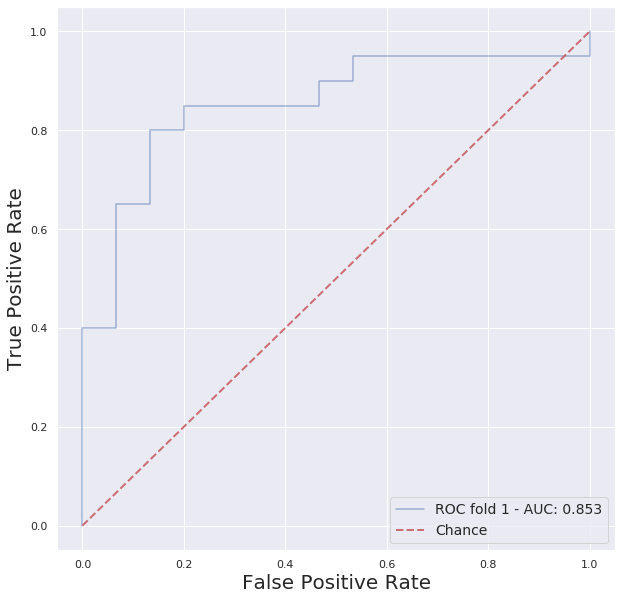

In [90]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(10,10))
for i, fold in enumerate(mega_folds):
    (fpr, tpr, thresholds), auc = get_roc_auc(fold)
    ax.plot(fpr, tpr, label=f'ROC fold {i+1} - AUC: {auc:.3f}', alpha=0.5)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
# mean_tpr[-1] = 1.0
# mean_auc = auc_score(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
# ax.plot(mean_fpr, mean_tpr, color='b',
#         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                 label=r'$\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
# ax.set_title(f"Receiver Operating Characteristic \nMedian Aggregration Cell Level Only\n AUC={mean_auc:.3f} $\pm${std_auc:.3f}", fontsize=24)
ax.legend(loc="lower right", fontsize=14)
ax.set_xlabel("False Positive Rate", fontsize=20)
ax.set_ylabel("True Positive Rate", fontsize=20)
plt.show()

In [91]:
# lets get the best threshold for the best effective accuracy
best_thresh = 0
most_correct = 0
for fold in mega_folds:
    for thresh in thresholds:
        correct = 0
        for order, values in fold.items():
            preds = np.median(values['predictions'])
            label = values['label']
            result = preds >= thresh
            if result == label:
                correct += 1
        if correct > most_correct:
            most_correct = correct
            best_thresh = thresh
true_positives = []
true_negatives = []
false_positives = []
false_negatives = []
for fold in mega_folds:
    for order, values in fold.items():
        preds = values['predictions']
        pred = np.median(preds)
        label = values['label']
        result = pred >= best_thresh
        if label == 0:
            if result == 0:
                true_negatives.append(preds)
            else:
                false_positives.append(preds)
        else:
            if result == 0:
                false_negatives.append(preds)
            else:
                true_positives.append(preds)

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt  

In [93]:
total = len(fold)

Text(0.5, 1, 'Normalized Confusion Matrix')

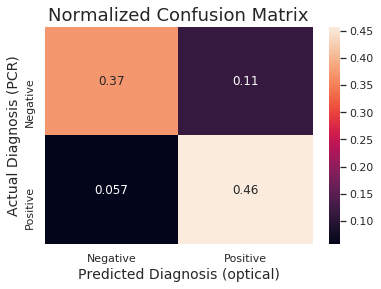

In [94]:
ax = plt.subplot()
confusion = np.array([[len(true_negatives), len(false_negatives)], [len(false_positives), len(true_positives)]])/total
sns.heatmap(confusion, ax=ax, annot=True)
ax.set_xlabel("Predicted Diagnosis (optical)", fontsize=14)
ax.set_ylabel("Actual Diagnosis (PCR)", fontsize=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Positive']);
ax.set_title("Normalized Confusion Matrix", fontsize=18)


Text(0.5, 1.0, 'Distribution of Predictions by Classification')

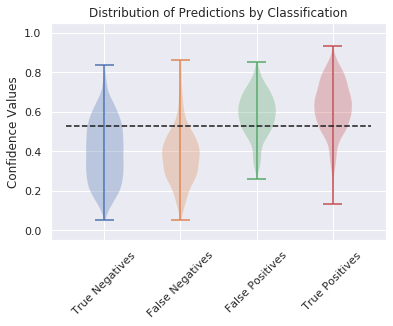

In [102]:
data = [true_negatives, false_negatives, false_positives, true_positives]
positions = np.arange(0, len(data))
plt.subplot()
for dat, pos in zip(data, positions):
    if len(dat):
        plt.violinplot([np.concatenate(dat)], [pos])
plt.xticks(positions, labels=['True Negatives', 'False Negatives', 'False Positives', 'True Positives'], rotation=45)
plt.ylabel("Confidence Values")
plt.ylim([-0.05, 1.05])
plt.hlines(best_thresh, -0.5, 3.5, linestyles='dashed')
plt.title("Distribution of Predictions by Classification")


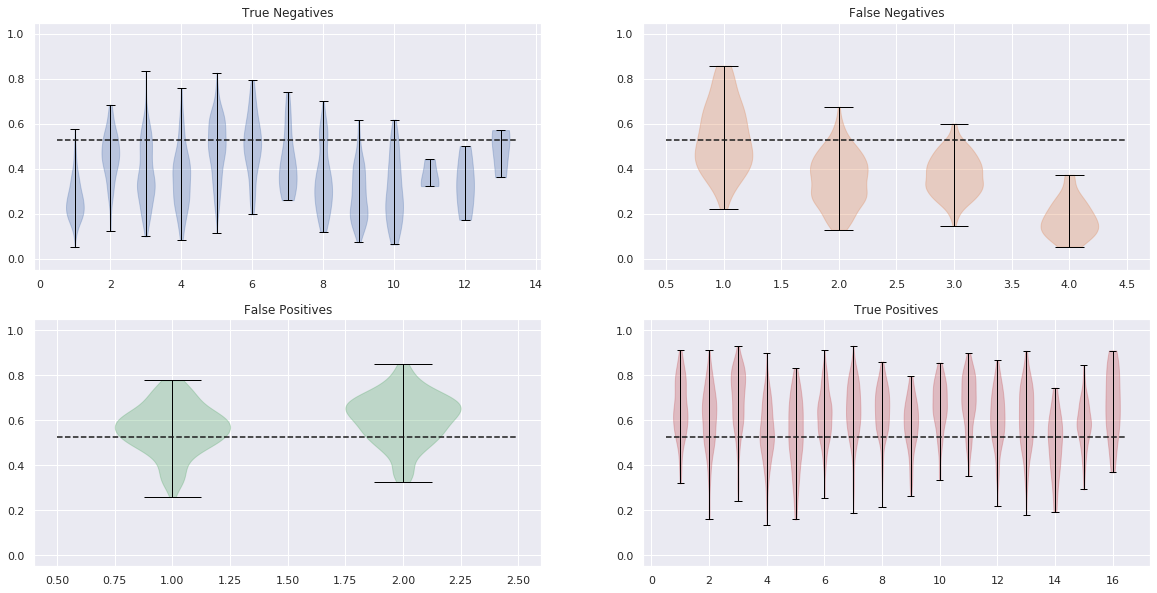

In [105]:
names = ['True Negatives', 'False Negatives', 'False Positives', 'True Positives']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
ind = 0
colors = sns.color_palette()
for dat, name in zip(data, names):
    ax = axs[ind//2][ ind % 2]
    if len(dat):
        parts = ax.violinplot(dat)
        for part in parts['bodies']:
            part.set_color(colors[ind])
            part.set_edgecolor(colors[ind])
        # Make all the violin statistics marks red:
        for partname in ('cbars','cmins','cmaxes',):
            vp = parts[partname]
            vp.set_edgecolor('black')
            vp.set_linewidth(1)
#             part.set_edgecolor(colors[ind])
    ax.set_title(name)
    ax.hlines(best_thresh, 0.5, len(dat) + 0.5, linestyles='dashed')

    ax.set_ylim([-0.05,1.05])
    ind += 1

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [32]:
fold

{'10049374259': {'predictions': array([0.99998331, 0.9999963 , 0.99750596, 0.99901009, 0.99962044,
         0.67705214, 0.99914742, 0.99887842, 0.98371041, 0.89664221,
         0.99998879, 0.93555778, 0.99999988, 0.99709749, 0.99998212,
         0.94823647, 0.99999523, 0.85421973, 0.99895227, 0.99403113,
         0.99890149, 0.01350063, 0.78682876, 0.9998908 , 0.99982709,
         0.9998216 , 0.94114333, 0.99999988, 0.99998736, 0.68880671,
         0.99881709, 0.99999249, 0.00352437, 0.9999851 , 0.99984002,
         0.99488848, 0.99614561, 0.79747593, 0.99089921, 0.99969697,
         0.99556619, 0.99963641, 0.99557894, 0.96653873, 0.99999678,
         0.9044013 , 0.99475658, 0.99526006, 0.99984968, 0.99999917,
         0.83033526, 0.97170842, 0.01578616, 0.98526114, 0.97867727,
         0.99385953, 0.98938483, 0.99999726, 0.92049992, 0.98144215,
         0.72520351, 0.99135262, 0.99982798, 0.74804765, 0.9651221 ,
         0.90098393, 0.99668026, 0.91287559, 0.99063432, 0.99458045,
    

In [52]:
wbc_types_by_patient = {}
wbc_data_path = '/home/colin/testing/wbc_class_1dr34rc5_v2.json'
with open(wbc_data_path) as fp:
    wbc_data = json.load(fp)
wbc_file_by_type = {cell_type:[] for cell_type in cell_types_li}
for filename, cell_type in wbc_data.items():
    wbc_file_by_type[cell_types_li[cell_type]].append(os.path.basename(filename))
for filename, cell_type in wbc_data.items():
    order = os.path.basename(filename).split('_')[0]
    try:
        int(order)
    except:
        order = os.path.basename(os.path.dirname(filename))
        int(order)
    if order not in wbc_types_by_patient:
        wbc_types_by_patient[order] = [0.0 for _ in range(9)]
    wbc_types_by_patient[order][cell_type] += 1
    

0.7950310559006211


134 27


In [72]:
134  / (134 + 27)

0.8322981366459627

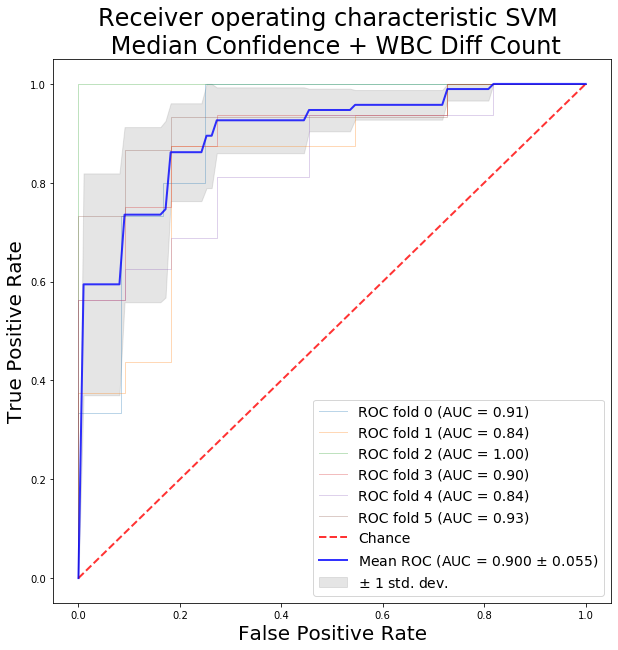

0.8385093167701864


In [87]:
tprs_rf = []
aucs_rf = []
mean_fpr_rf = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(10,10))
preds = []
ag_method = 'median'
for i, fold in enumerate(folds):
    x_data_train = []
    y_data_train = []
    x_data_test = []
    y_data_test = []
    all_patients
    for patient in fold.keys():
        wbc_types = np.array(wbc_types_by_patient[patient])
        wbc_dist = (wbc_types/np.sum(wbc_types)).tolist()
        features = wbc_dist
#         features = []
        conf = aggregate_scores(fold[patient]['predictions'], method=ag_method)
        features += [conf]
        y_data_test.append(fold[patient]['label'])
        x_data_test.append(features)
    for patient in all_patients.keys():
        if patient in fold:
            continue
        wbc_types = np.array(wbc_types_by_patient[patient])
        wbc_dist = (wbc_types/np.sum(wbc_types)).tolist()
        features = wbc_dist
#         features = []
        conf = aggregate_scores(all_patients[patient]['predictions'], method=ag_method)
        features += [conf]
        y_data_train.append(all_patients[patient]['label'])
        x_data_train.append(features)
    classifier = SVC(C=0.5, gamma=1.2)
    classifier.fit(x_data_train, y_data_train)
    viz = plot_roc_curve(classifier, x_data_test, y_data_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr_rf = np.interp(mean_fpr_rf, viz.fpr, viz.tpr)
    interp_tpr_rf[0] = 0.0
    tprs_rf.append(interp_tpr_rf)
    aucs_rf.append(viz.roc_auc)
    preds.append(classifier.predict(x_data_test) == y_data_test)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = auc_score(mean_fpr_rf, mean_tpr_rf)
std_auc_rf = np.std(aucs_rf)
ax.plot(mean_fpr_rf, mean_tpr_rf, color='b',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_rf, std_auc_rf),
        lw=2, alpha=.8)
std_tpr_rf = np.std(tprs_rf, axis=0)
tprs_upper_rf = np.minimum(mean_tpr_rf + std_tpr_rf, 1)
tprs_lower_rf = np.maximum(mean_tpr_rf - std_tpr_rf, 0)
ax.fill_between(mean_fpr_rf, tprs_lower_rf, tprs_upper_rf, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_title("Receiver operating characteristic SVM \n Median Confidence + WBC Diff Count", fontsize=24)
ax.legend(loc="lower right", fontsize=14)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
plt.show()
good = 0
bad = 0
for pred in preds:
    for p in pred:
        if p:
            good +=1
        else:
            bad += 1
print(good/(good + bad))

In [81]:
cpreds = np.concatenate(preds)
np.sum(cpreds)/len(cpreds)

0.8385093167701864

In [24]:
for i, (train, test) in enumerate(cv.split(X, y)):
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic Random Forest \n Mean Confidence + WBC Diff Count")
ax.legend(loc="lower right")
plt.show()

IndentationError: expected an indented block (<ipython-input-24-b2e5672ef1be>, line 3)

In [63]:
# lets get the best acc
thresholds = np.linspace(0,1,1000)
all_confs = np.array([aggregate_scores(data['predictions']) for data in all_patients.values()])
labels = np.array([data['label'] for data in all_patients.values()])

In [64]:
acc = 0
t = 0
for thresh in thresholds:
    tt = all_confs > thresh
    new_acc = np.count_nonzero(tt == labels)/len(tt)
    if new_acc > acc:
        acc = new_acc
        

In [65]:
acc

0.8385093167701864

In [27]:
with open('/home/colin/testing/wbc_class_1dr34rc5_v2_cont.json') as fp:
    cont_data = json.load(fp)
soft_data = {key:softmax(value) for key, value in cont_data.items()}
soft_base = {os.path.basename(key):softmax(value) for key, value in cont_data.items()}

In [28]:
low_conf_files = []
for key, value in soft_base.items():
    if np.max(value)

SyntaxError: invalid syntax (<ipython-input-28-2538d7b3cd23>, line 3)

In [29]:
# lets hack our way to an accuracy score
users = ['colin', 'shiqi', 'kanghyun', 'xing', 'sam', 'vinayak']
folders = ['review_rev3', 'review', 'review', 'review', 'review', 'review']

In [30]:
with open('/home/colin/testing/wbc_class_1dr34rc5.json') as fp:
    wbc_class_data = json.load(fp)
    wbc_class_data = {os.path.basename(f): k for f,k in wbc_class_data.items()}

In [31]:
done_images = []
good_by_type = {cell_type:[] for cell_type in cell_types_li}
for user, folder in zip(users, folders):
    done_folders = glob.glob(os.path.join(f'/home/{user}', folder, '*_done'))
    for done_folder in done_folders:
        images = [os.path.basename(f) for f in glob.glob(os.path.join(done_folder, '*.jpg'))]
        for cell_type in cell_types_li:
            if cell_type in done_folder:
                good_by_type[cell_type] += images
        done_images += images
done_images = set(done_images)

In [32]:
misclassified = {k:s for k,s in wbc_class_data.items() if k not in done_images}

In [33]:
overall = [0 for _ in range(9)]
for _, cls in wbc_class_data.items():
    overall[cls] += 1
misc = [0 for _ in range(9)]
for file, cls in misclassified.items():
    misc[cls] += 1

In [34]:
confs = [[] for _ in range(9)]
misc_confs = [[] for _ in range(9)]

In [35]:
for file, conf in soft_base.items():
    ind = np.argmax(conf)
    confs[ind].append(conf[ind])
    if file in misclassified:
        misc_confs[ind].append(conf[ind])

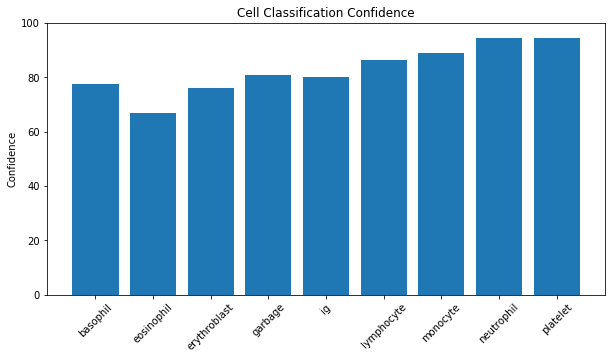

In [36]:
plt.figure(figsize=(10, 5))
plt.title("Cell Classification Confidence")
x_data = np.arange(0, 9)
y_data = np.array(([np.mean(c) for c in confs]))*100
plt.bar(x_data, y_data)
plt.xticks(ticks=x_data, labels=cell_types_li, rotation=45)
plt.ylabel("Confidence")
plt.ylim(0, 100)
plt.show()

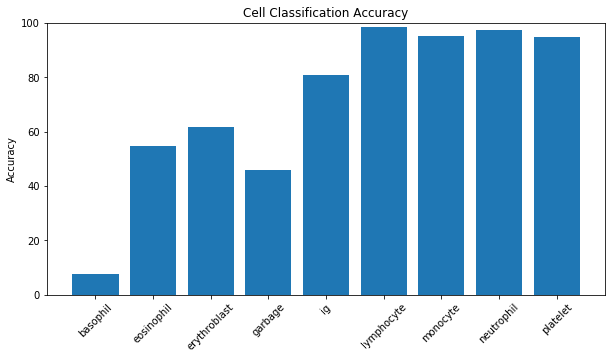

In [37]:
plt.figure(figsize=(10, 5))
plt.title("Cell Classification Accuracy")
x_data = np.arange(0, 9)
y_data = (1 - np.array(misc)/np.array(overall))*100
plt.bar(x_data, y_data)
plt.xticks(ticks=x_data, labels=cell_types_li, rotation=45)
plt.ylabel("Accuracy")
plt.ylim(0, 100)
plt.show()

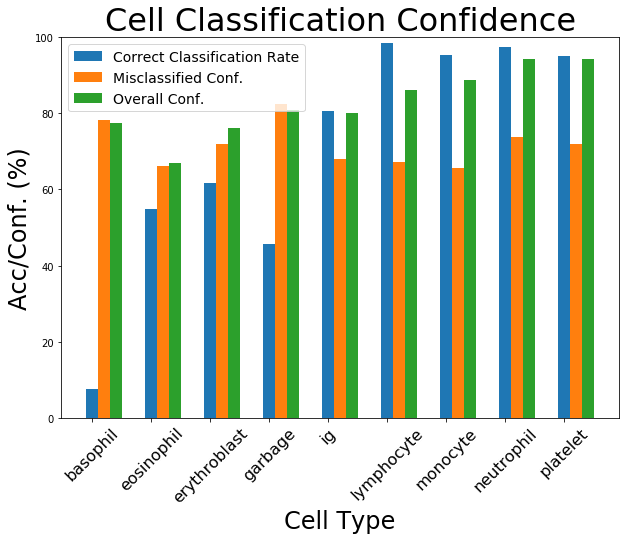

In [38]:
plt.figure(figsize=(10, 7))
plt.title("Cell Classification Confidence", fontsize=32)
width = 0.2
x_data = np.arange(0, 9)
y_data = (1 - np.array(misc)/np.array(overall))*100
x_data_2 = np.arange(0, 9) + width
y_data_2 = np.array(([np.mean(c) for c in misc_confs]))*100
x_data_3 = np.arange(0, 9) + 2*width
y_data_3 = np.array(([np.mean(c) for c in confs]))*100
plt.bar(x_data, y_data, width=width, label='Correct Classification Rate')
plt.bar(x_data_2, y_data_2, width=width, label="Misclassified Conf.")
plt.bar(x_data_3, y_data_3, width=width, label="Overall Conf.")
plt.xticks(ticks=x_data, labels=cell_types_li, rotation=45, fontsize=16)
plt.ylabel("Acc/Conf. (%)", fontsize=24)
plt.xlabel("Cell Type", fontsize=24)
plt.ylim(0, 100)
plt.legend(fontsize=14)
plt.show()

In [39]:
miscs = [[] for _ in range(9)]
confs = [[] for _ in range(9)]
for filename, conf in soft_data.items():
    name = os.path.basename(filename)
    if name in misclassified:
        ind = np.argmax(conf)
        miscs[ind].append(filename)
        confs[ind].append(conf[ind])

FileNotFoundError: [Errno 2] No such file or directory: '/hddraid5/data/colin/covid-data/COVID Research Images/April 27, 2020/April 27 2020/10049502684/Not WBC/10049502684_064.jpg'

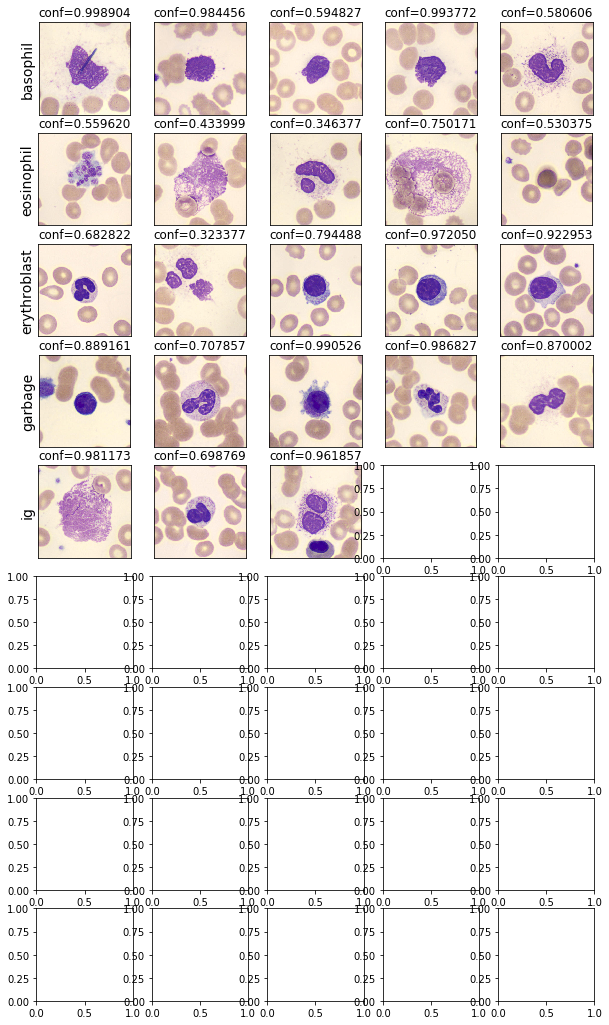

In [40]:
fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(5*2, 9*2))
for i, cell_type in enumerate(cell_types_li):
    sample_inds = np.random.choice(np.arange(0, len(miscs[i])), size=5, replace=False)
    axs[i][0].set_ylabel(cell_type, fontsize=14)
    for j, sample_ind in enumerate(sample_inds):
        image = PIL.Image.open(miscs[i][sample_ind])
        axs[i][j].imshow(image)
        axs[i][j].set_title(f"conf={confs[i][sample_ind]:2f}")
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        

In [ ]:
miscs = [[] for _ in range(9)]
confs = [[] for _ in range(9)]
for filename, conf in soft_data.items():
    name = os.path.basename(filename)
    if name not in misclassified:
        ind = np.argmax(conf)
        miscs[ind].append(filename)
        confs[ind].append(conf[ind])

In [ ]:
fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(5*2, 9*2))
for i, cell_type in enumerate(cell_types_li):
    sample_inds = np.random.choice(np.arange(0, len(miscs[i])), size=5, replace=False)
    axs[i][0].set_ylabel(cell_type, fontsize=14)
    for j, sample_ind in enumerate(sample_inds):
        image = PIL.Image.open(miscs[i][sample_ind])
        axs[i][j].imshow(image)
        axs[i][j].set_title(f"conf={confs[i][sample_ind]:2f}")
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        

[0.45679980516433716,
 0.07835016399621964,
 0.5788345336914062,
 0.29945090413093567,
 0.285994291305542,
 0.1695939153432846,
 0.18265391886234283,
 0.9865409731864929,
 0.7789723873138428,
 0.8016903400421143,
 0.9442166090011597,
 0.72906494140625,
 0.1574050784111023,
 0.9468820691108704,
 0.9926371574401855,
 0.36276674270629883,
 0.7558324337005615,
 0.9098243713378906,
 0.8040865659713745,
 0.719585120677948,
 0.9238383173942566,
 0.9732118248939514,
 0.0667819157242775,
 0.4093567430973053,
 0.01844618283212185,
 0.6555971503257751,
 0.3512537181377411,
 0.9749920964241028,
 0.5226488709449768,
 0.07423418015241623,
 0.9815583825111389,
 0.18286602199077606,
 0.7910940051078796,
 0.6412107944488525,
 0.3065612018108368,
 0.747292697429657,
 0.07658716291189194,
 0.7999645471572876,
 0.9127168655395508,
 0.9606462717056274,
 0.6002558469772339,
 0.9875308871269226,
 0.9696201086044312,
 0.5874869227409363,
 0.08638870716094971,
 0.05409311130642891,
 0.21530264616012573,
 0.946

In [248]:
# lets look through all the folds and try to figure out which cells are good/bad
fold_num = 0
fold_select = all_folds[0]
patient_select = list(fold_select[0].keys())
covid_cells = {}
clean_cells = {}
ssfs = []
for patient in patient_select:
    label = fold_select[0][patient]['label']
    if label == 0:
        clean_cells[patient] = []
    else:
        covid_cells[patient] = []
    for fold in fold_select:
        cell_scores = np.array(fold[patient]['predictions'])
        if label == 0:
            good_cell_mask = np.abs((cell_scores - label)) > 0.9
        else:
            good_cell_mask = np.abs((cell_scores - label)) > 0.9
        files = np.array(fold[patient]['files'])
        if label == 0:
            clean_cells[patient].append(files[good_cell_mask])
        else:
            covid_cells[patient].append(files[good_cell_mask])

In [249]:
def in_all(arrays):
    sets = []
    assert len(arrays) > 0
    src_array = arrays[0]
    dst_arrays = arrays[1:]
    good_els = []
    for el in src_array:
        good = True
        for dst in dst_arrays:
            if el not in dst:
                good = good and False
        if good:
            good_els.append(el)
    return good_els

def get_image(filename, all_images):
    for image in all_images:
        if filename in image:
            return image
    raise RuntimeError()

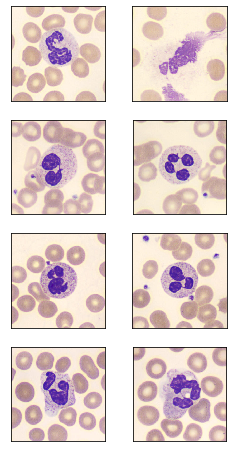

In [250]:
consistent_clean = []
for patient, clean_cell_li in clean_cells.items():
    gl = clean_cell_li[0][0:10]
    if len(gl) >= 2:
        consistent_clean.append([get_image(g, all_images) for g in gl])
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(4, 8))
for i, const in enumerate(consistent_clean[0:4]):
    axs[i,0].imshow(PIL.Image.open(const[0]))
    axs[i,1].imshow(PIL.Image.open(const[1]))
    axs[i,0].set_xticks([])
    axs[i,1].set_xticks([])
    axs[i,0].set_yticks([])
    axs[i,1].set_yticks([])
plt.show()

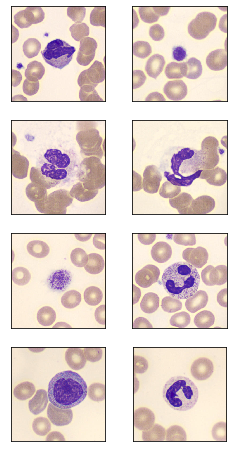

In [251]:
consistent_covid = []
for patient, covid_cell_li in covid_cells.items():
    gl = covid_cell_li[0][0:10]
    if len(gl) >= 2:
        consistent_covid.append([get_image(g, all_images) for g in gl])
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(4, 8))
for i, const in enumerate(consistent_covid[0:4]):
    axs[i,0].imshow(PIL.Image.open(const[0]))
    axs[i,1].imshow(PIL.Image.open(const[1]))
    axs[i,0].set_xticks([])
    axs[i,1].set_xticks([])
    axs[i,0].set_yticks([])
    axs[i,1].set_yticks([])
plt.show()

In [213]:
consistent_covid

[['/hddraid5/data/colin/covid-data/COVID Research Images/April 29 2020/10049403339/10049403339_064.jpg',
  '/hddraid5/data/colin/covid-data/COVID Research Images/April 29 2020/10049403339/10049403339_055.jpg',
  '/hddraid5/data/colin/covid-data/COVID Research Images/April 29 2020/10049403339/10049403339_126.jpg',
  '/hddraid5/data/colin/covid-data/COVID Research Images/April 29 2020/10049403339/10049403339_134.jpg',
  '/hddraid5/data/colin/covid-data/COVID Research Images/April 29 2020/10049403339/10049403339_033.jpg',
  '/hddraid5/data/colin/covid-data/COVID Research Images/April 29 2020/10049403339/10049403339_137.jpg',
  '/hddraid5/data/colin/covid-data/COVID Research Images/April 29 2020/10049403339/10049403339_115.jpg'],
 ['/hddraid5/data/colin/covid-data/COVID Research Images/April 28, 2020/April 28 2020/10049315602/10049315602_157.jpg',
  '/hddraid5/data/colin/covid-data/COVID Research Images/April 28, 2020/April 28 2020/10049315602/10049315602_056.jpg',
  '/hddraid5/data/colin/

In [183]:
all_images = glob.glob(f'/hddraid5/data/colin/covid-data/COVID Research Images/**/*.jpg', recursive=True)

In [187]:
get_image(gl[0], all_images)

'/hddraid5/data/colin/covid-data/COVID Research Images/April 27, 2020/April 27 2020/10049502116/10049502116_164.jpg'

In [184]:
len(all_images)

24369

In [176]:
images = []

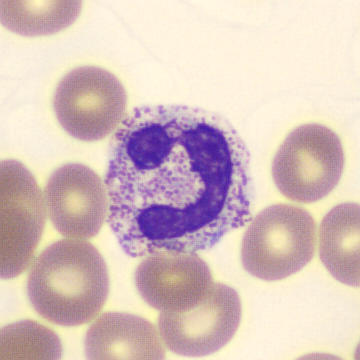

In [179]:
PIL.Image.open(images[0])

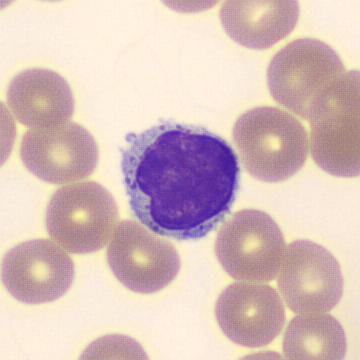

In [180]:
PIL.Image.open(images[1])

In [174]:
gl

['10049502116_164.jpg', '10049502116_131.jpg']

In [171]:
clean_cells

{'10049502116': [array(['10049502116_200.jpg', '10049502116_054.jpg',
         '10049502116_050.jpg', '10049502116_137.jpg',
         '10049502116_043.jpg', '10049502116_165.jpg',
         '10049502116_134.jpg', '10049502116_061.jpg',
         '10049502116_103.jpg', '10049502116_187.jpg',
         '10049502116_184.jpg', '10049502116_143.jpg',
         '10049502116_078.jpg', '10049502116_149.jpg',
         '10049502116_170.jpg', '10049502116_164.jpg',
         '10049502116_174.jpg', '10049502116_093.jpg',
         '10049502116_136.jpg', '10049502116_072.jpg',
         '10049502116_097.jpg', '10049502116_199.jpg',
         '10049502116_155.jpg', '10049502116_056.jpg',
         '10049502116_131.jpg', '10049502116_044.jpg',
         '10049502116_031.jpg', '10049502116_202.jpg',
         '10049502116_084.jpg', '10049502116_092.jpg',
         '10049502116_157.jpg', '10049502116_201.jpg',
         '10049502116_147.jpg', '10049502116_063.jpg',
         '10049502116_067.jpg', '10049502116_133.j

In [149]:
clean_cell_arr

[array(['10049502116_165.jpg', '10049502116_084.jpg',
        '10049502116_056.jpg', '10049502116_149.jpg',
        '10049502116_144.jpg'], dtype='<U19'),
 array(['10049502116_077.jpg', '10049502116_087.jpg',
        '10049502116_078.jpg', '10049502116_185.jpg',
        '10049502116_100.jpg'], dtype='<U19'),
 array(['10049502116_131.jpg', '10049502116_164.jpg',
        '10049502116_037.jpg', '10049502116_054.jpg',
        '10049502116_134.jpg'], dtype='<U19')]

In [145]:
covid_cells

[['10049403339_126.jpg', '10049403339_152.jpg', '10049403339_014.jpg'],
 ['10049315602_039.jpg', '10049315602_113.jpg', '10049315602_034.jpg'],
 ['10049489999_126.jpg', '10049489999_113.jpg', '10049489999_113.jpg'],
 ['10049376321_050.jpg', '10049376321_010.jpg', '10049376321_048.jpg'],
 ['10049665434_120.jpg', '10049665434_078.jpg', '10049665434_134.jpg'],
 ['10049805624_099.jpg', '10049805624_017.jpg', '10049805624_132.jpg'],
 ['10049492968_070.jpg', '10049492968_095.jpg', '10049492968_095.jpg'],
 ['10049660606_138.jpg', '10049660606_043.jpg', '10049660606_158.jpg'],
 ['10049496932_057.jpg', '10049496932_079.jpg', '10049496932_069.jpg'],
 ['10049306422_124.jpg', '10049306422_061.jpg', '10049306422_056.jpg'],
 ['10049401861_124.jpg', '10049401861_108.jpg', '10049401861_108.jpg'],
 ['10049320321_013.jpg', '10049320321_034.jpg', '10049320321_058.jpg'],
 ['10049749375_056.jpg', '10049749375_056.jpg', '10049749375_109.jpg'],
 ['10049404062_108.jpg', '10049404062_108.jpg', '10049404062_027

In [142]:
good_cells

['10049403339_227.jpg', '10049403339_227.jpg', '10049403339_227.jpg']

In [141]:
ssfs[1]

array(['10049403339_227.jpg', '10049403339_253.jpg',
       '10049403339_276.jpg', '10049403339_302.jpg',
       '10049403339_245.jpg', '10049403339_180.jpg',
       '10049403339_186.jpg', '10049403339_280.jpg',
       '10049403339_197.jpg', '10049403339_313.jpg',
       '10049403339_190.jpg', '10049403339_223.jpg',
       '10049403339_247.jpg', '10049403339_171.jpg',
       '10049403339_174.jpg', '10049403339_273.jpg',
       '10049403339_303.jpg', '10049403339_295.jpg',
       '10049403339_263.jpg', '10049403339_255.jpg',
       '10049403339_297.jpg', '10049403339_236.jpg',
       '10049403339_178.jpg', '10049403339_275.jpg',
       '10049403339_203.jpg', '10049403339_215.jpg',
       '10049403339_270.jpg', '10049403339_287.jpg',
       '10049403339_254.jpg', '10049403339_217.jpg',
       '10049403339_153.jpg', '10049403339_181.jpg',
       '10049403339_029.jpg', '10049403339_192.jpg',
       '10049403339_220.jpg', '10049403339_196.jpg',
       '10049403339_284.jpg', '10049403339_233

In [132]:
np.array(fold_select[1][patient]['files'])

array(['10049403339_276.jpg', '10049403339_294.jpg',
       '10049403339_222.jpg', '10049403339_296.jpg',
       '10049403339_246.jpg', '10049403339_270.jpg',
       '10049403339_159.jpg', '10049403339_146.jpg',
       '10049403339_098.jpg', '10049403339_219.jpg',
       '10049403339_012.jpg', '10049403339_286.jpg',
       '10049403339_192.jpg', '10049403339_010.jpg',
       '10049403339_120.jpg', '10049403339_200.jpg',
       '10049403339_156.jpg', '10049403339_161.jpg',
       '10049403339_022.jpg', '10049403339_054.jpg',
       '10049403339_015.jpg', '10049403339_090.jpg',
       '10049403339_197.jpg', '10049403339_092.jpg',
       '10049403339_283.jpg', '10049403339_177.jpg',
       '10049403339_143.jpg', '10049403339_064.jpg',
       '10049403339_168.jpg', '10049403339_191.jpg',
       '10049403339_155.jpg', '10049403339_230.jpg',
       '10049403339_020.jpg', '10049403339_140.jpg',
       '10049403339_250.jpg', '10049403339_112.jpg',
       '10049403339_042.jpg', '10049403339_314

In [110]:
pred

0.6281999349594116

In [108]:
label

0